In [14]:
import torch
import torchvision
import torchvision.transforms as transforms

# Prepare the Dataset

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Visualize the Dataset
In this part, a batch from the dataset is visualized and corresponding labels are printed

torch.Size([4, 3, 32, 64])


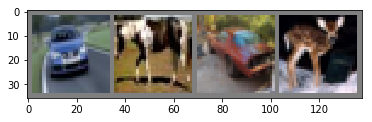

  car horse   car  deer


In [18]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(img_wide.size())

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define the network

In [19]:
class NetWide(nn.Module):
    def __init__(self):
        super(NetWide, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
#         self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 4 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # x [b,3,32,64]
        x = self.pool(F.relu(self.conv1(x))) # [b,6,16,32]
        x = self.pool(F.relu(self.conv2(x))) # [b,16,8,16]
        x = self.pool(F.relu(self.conv3(x))) # [b,32,4,8]
#         x = self.pool(F.relu(self.conv4(x))) # [b,3,2,4]
        x = x.view(-1, 32 * 4 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)


net_wide = NetWide().cuda()

# Define the loss and optimizer
We are using binary cross entropy loss (`BCELoss`) and stochastic gradient descent optimizer

In [20]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.SGD(net_wide.parameters(), lr=0.001, momentum=0.9)

# Perform the traning
Training is performed inside two `for` loops. One of them iterates on number of epochs and the other one is iterating over one epoch.

In [21]:
epochs = 2
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        labels_one = F.one_hot(labels, num_classes=10).float()
#         index = torch.randint(10, labels.size()).type_as(labels)

        index = torch.randperm(4)
        inputs_2 = inputs[index, :,:,:]
        labels_2 = labels[index]
        labels_one_2 = F.one_hot(labels_2, num_classes=10).float()
#         print(labels.size())
        
        inputs_wide = torch.cat((inputs, inputs_2), dim=-1)
        labels_wide = 0.5*labels_one + 0.5*labels_one_2

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
#         outputs = net(inputs)
        outputs = net_wide(inputs_wide)
        loss = criterion(outputs, labels_wide)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
#             print(F.one_hot(labels, num_classes=10))
#             print(labels)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.388
[1,  4000] loss: 0.327
[1,  6000] loss: 0.326
[1,  8000] loss: 0.326
[1, 10000] loss: 0.326
[1, 12000] loss: 0.325
[2,  2000] loss: 0.325
[2,  4000] loss: 0.325
[2,  6000] loss: 0.325
[2,  8000] loss: 0.325
[2, 10000] loss: 0.323
[2, 12000] loss: 0.320
Finished Training


## Save the weights of the trained network

In [10]:
PATH = './cifar_net.pth'
torch.save(net_wide.state_dict(), PATH)

# Testing the Network
Take one batch from the test dataset, visualize the images and print the labels. 

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# images, labels = images.cuda(), labels.cuda()
index = torch.randperm(4)
images_2 = images[index, :,:,:]
labels_2 = labels[index]

images_wide = torch.cat((images, images_2), dim=-1)

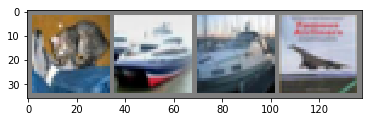

GroundTruth:    cat  ship  ship plane


In [12]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

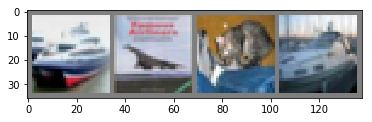

GroundTruth:   ship plane   cat  ship


In [13]:
imshow(torchvision.utils.make_grid(images_2))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[index[j]]] for j in range(4)))

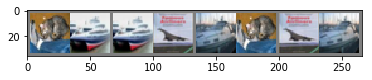

GroundTruth:    cat  ship  ship plane


In [14]:
imshow(torchvision.utils.make_grid(images_wide))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Test with the wide network
Load the trained network trained with two conctanated images from CIFAR10

In [15]:
net_wide = NetWide()
net_wide.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Then calculate the output for one batch and print the predicted labels 

In [16]:
outputs = net_wide(images_wide)

In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship  ship  ship  ship


In [12]:
## Print the predicted two classes

In [13]:
_,predicted = outputs.sort(dim=1, descending=True)

print('Predicted First Class: ', ' '.join('%5s' % classes[predicted[j,0]]
                              for j in range(4)))
print('Predicted Second Class: ', ' '.join('%5s' % classes[predicted[j,1]]
                              for j in range(4)))

Predicted First Class:  horse   car plane plane
Predicted Second Class:  truck truck horse horse


## Iterate over the whole test dataset
Then the accuracy of the trained network on test dataset is calculated.

In [8]:
net_wide = net_wide.cuda()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        index = torch.randperm(4)
        images_2 = images[index, :,:,:]
        labels_2 = labels[index]
        images_wide = torch.cat((images,images_2), dim=-1)
        outputs = net_wide(images_wide)
        _, predicted = torch.max(outputs.data, 1)
#         _,predicted = outputs.sort(dim=1, descending=True)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 26 %
